In [1]:
import pandas as pd
import numpy as np
from enum import Enum
import chess
from pathlib import Path
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.cuda.is_available():
    device = "cuda" 
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name())
else:
    device = "cpu"
    
device

CUDA version: 12.9
GPU: NVIDIA GeForce RTX 3070


'cuda'

In [3]:
"""
(57.35%) 1,456,135 v1 - 775-1024(p=0.1)-512(p=0.2)-256(p=0.5)-7
(58.15%) 1,496,327 v2 - 775-1024(p=0.1)-512(p=0.2)-256(p=0.2)-128(p=0.2)-64(p=0.1)-7
(57.79%) 1,488,391 v3 - 775-1024(p=0.1)-512(p=0.2)-256(p=0.2)-128(p=0.5)-7

Main
(57.35%) 1,456,135 v1 - 775-1024(p=0.1)-512(p=0.2)-256(p=0.5)-7 
(58.18%) 1,323,015 v4 - 775-512(p=0.2)-512(p=0.3)-512(p=0.3)-512(p=0.3)-256(p=0.4)-7
(%) 1,983,495, v5 - 775-1024(p=0.2)-512(p=0.2)-512(p=0.2)-512(p=0.2)-256(p=0.5)-7
"""

'\n(57.35%) 1,456,135 v1 - 775-1024(p=0.1)-512(p=0.2)-256(p=0.5)-7\n(58.15%) 1,496,327 v2 - 775-1024(p=0.1)-512(p=0.2)-256(p=0.2)-128(p=0.2)-64(p=0.1)-7\n(57.79%) 1,488,391 v3 - 775-1024(p=0.1)-512(p=0.2)-256(p=0.2)-128(p=0.5)-7\n\nMain\n(57.35%) 1,456,135 v1 - 775-1024(p=0.1)-512(p=0.2)-256(p=0.5)-7 \n(58.18%) 1,323,015 v4 - 775-512(p=0.2)-512(p=0.3)-512(p=0.3)-512(p=0.3)-256(p=0.4)-7\n(%) 1,983,495, v5 - 775-1024(p=0.2)-512(p=0.2)-512(p=0.2)-512(p=0.2)-256(p=0.5)-7\n'

In [4]:
RUN_ID = "run_2026_01_22_probs_mlp_v5"
model_save_name = "probs_mlp_v5"

In [5]:
class ChessDataset(Dataset):
    def __init__(self, root_dir: Path, split: str, sigma: float = 0.6):
        self.root_dir = Path(root_dir)
        self.split = split
        self.sigma = sigma
        self.num_classes = 7
        self.class_indices = torch.arange(self.num_classes, dtype=torch.float32)
        self.X = np.load(self.root_dir / f"{self.split}_X.npy", mmap_mode='r')
        self.y = np.load(self.root_dir / f"{self.split}_y.npy", mmap_mode='r')
        self.scores = np.load(self.root_dir / f"{self.split}_scores.npy", mmap_mode='r')

    def __len__(self) -> int:
        return self.X.shape[0]

    def score_to_continuous_index(self, score: float) -> float:
        """
        Maps Centipawn score to a continuous index (e.g. 400cp -> 1.5).
        """
        
        if score >= 500: 
            # Fade from 0.5 (at 500) to 0.0 (at 700)
            return max(0.0, 0.5 - (score - 500) / 200.0)
        
        if score <= -500:
            # Fade from 5.5 (at -500) to 6.0 (at -700)
            return min(6.0, 5.5 + (-500 - score) / 200.0)
        
        # Interpolate the Middle Classes
        # 300 to 500  -> Maps to 1.5 to 0.5
        if score >= 300: return 1.5 - (score - 300) / 200.0
        # 100 to 300  -> Maps to 2.5 to 1.5
        if score >= 100: return 2.5 - (score - 100) / 200.0
        # -100 to 100 -> Maps to 3.5 to 2.5
        if score >= -100: return 3.5 - (score - (-100)) / 200.0
        # -300 to -100 -> Maps to 4.5 to 3.5
        if score >= -300: return 4.5 - (score - (-300)) / 200.0
        # -500 to -300 -> Maps to 5.5 to 4.5
        if score > -500: return 5.5 - (score - (-500)) / 200.0
        
        return 3.0 
    
    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        score = self.scores[idx].item()
        target_idx = self.score_to_continuous_index(score)
        
        # Create Gaussian Distribution centered at target_idx
        dist = torch.exp(-((self.class_indices - target_idx) ** 2) / (2 * self.sigma ** 2))
        
        # Normalize so it sums to 1.0
        soft_target = dist / dist.sum()
        
        x_tensor = torch.tensor(self.X[idx], dtype=torch.float32)
        hard_label = torch.tensor(self.y[idx], dtype=torch.long)

        # return self.X[idx], self.y[idx]
        return x_tensor, soft_target, hard_label

In [6]:
BATCH_SIZE = 512
num_workers = 0 
ROOT_DIR = Path("./dataset_bitmaps_cp/")

train_dataset = ChessDataset(root_dir=ROOT_DIR, split="train")
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE, 
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)

val_dataset = ChessDataset(root_dir=ROOT_DIR, split="val")
val_dataloader = DataLoader(dataset=val_dataset, 
                            batch_size=BATCH_SIZE, 
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory=True)

test_dataset = ChessDataset(root_dir=ROOT_DIR, split="test")
test_dataloader = DataLoader(dataset=test_dataset, 
                             batch_size=BATCH_SIZE, 
                             num_workers=num_workers,
                             shuffle=False,
                             pin_memory=True)

In [7]:
import time

start = time.time()
for i, (X, y, y_hard) in enumerate(train_dataloader):
    if i == 100:  # measure 100 batches
        break
print("Avg batch load time:", (time.time() - start) / 100)


Avg batch load time: 0.03725892066955566


In [8]:
Xb, _, yb = next(iter(train_dataloader))
print("X batch shape:", Xb.shape, "dtype:", Xb.dtype)
print("y batch shape:", yb.shape, "dtype:", yb.dtype)

X batch shape: torch.Size([512, 775]) dtype: torch.float32
y batch shape: torch.Size([512]) dtype: torch.int64


In [9]:
class PositionLabel(Enum):
    WHITE_WINNING = 0
    WHITE_DECISIVE = 1
    WHITE_BETTER = 2
    EQUAL = 3
    BLACK_BETTER = 4
    BLACK_DECISIVE = 5
    BLACK_WINNING = 6

In [10]:
class MLP(nn.Module):
    def __init__(self, input_shape=775, output_shape=7):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_shape, 1024), 
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, output_shape)
        )

    def forward(self, x):
        return self.network(x)

In [11]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scaler: torch.amp.GradScaler,
               device=device) -> tuple[float, float]:
    """
    Performs one training epoch for the given model.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y, _) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # X and Y are both shape (BATCH_SIZE,)

        # Reset gradients
        optimizer.zero_grad()

        # Forward Pass
        with torch.amp.autocast(device):
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
        
        # Backpropagation
        scaler.scale(loss).backward()

        # Update weights
        scaler.step(optimizer)
        scaler.update()  
        
        train_loss += loss.item()

        # Calculate accuracy metrics
        """softmax and argmax dim=1 because tensor of shape (batchsize, num_classes)"""
        y_pred_class = torch.argmax(y_pred, dim=-1) # y_pred_class.shape = (BATCH_SIZE,)
        # train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        # Remove for non prob ablation
        y_true_class = torch.argmax(y, dim=-1)
        train_acc += (y_pred_class == y_true_class).sum().item()/len(y_pred)
        
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [12]:
def eval_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device) -> tuple[float, float]:
    """
    Evaluates the given model on the given dataloader without gradient updates.
    Dataloader should either be the validation or test dataloader.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in eval mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y, y_hard) in enumerate(dataloader):
            X, y, y_hard = X.to(device), y.to(device), y_hard.to(device)

            # Forward Pass
            test_pred = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate accuracy metrics
            test_pred_labels = torch.argmax(test_pred, dim=1)
            test_acc += (test_pred_labels == y_hard).sum().item() / len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [13]:
from tqdm import tqdm
import copy

def run_experiment(model: torch.nn.Module,
                   model_save_name: str,
                   train_dataloader: torch.utils.data.DataLoader,
                   val_dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer,
                   scaler: torch.amp.GradScaler,
                   epochs: int,
                   patience: int,
                   device=device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}
    
    best_val_acc = 0.0
    best_model_weights = None
    patience_counter = 0 
    
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode='min', factor=0.1, patience=3
    # )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=epochs,      
        eta_min=1e-6         
    )
    
    print(f"Starting Training: {model_save_name}")

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device,
                                           scaler=scaler)
        val_loss, val_acc = eval_step(model=model,
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)
        
        # scheduler.step(val_loss)
        scheduler.step()
        
        if val_acc > best_val_acc: 
            best_val_acc = val_acc
            best_model_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
            
            print(f"Epoch: {epoch} | New Best Val Acc: {val_acc:.4f} (Saved)")
            torch.save(model.state_dict(), f"models/{model_save_name}.pth")
        else:
            patience_counter += 1
            print(f"Epoch: No improvement. Patience {patience_counter}/{patience}")

        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        if patience_counter >= patience:
            print(f"\n[Early Stopping] No improvement for {patience} epochs. Stopping.")
            break 

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"\nLoaded best model weights with Val Acc: {best_val_acc:.4f}")

    return results

In [14]:
from torchinfo import summary

model = MLP(input_shape=775, 
            output_shape=7).to(device)

summary(model, input_size=(BATCH_SIZE,775))


Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [512, 7]                  --
├─Sequential: 1-1                        [512, 7]                  --
│    └─Linear: 2-1                       [512, 1024]               794,624
│    └─BatchNorm1d: 2-2                  [512, 1024]               2,048
│    └─ReLU: 2-3                         [512, 1024]               --
│    └─Dropout: 2-4                      [512, 1024]               --
│    └─Linear: 2-5                       [512, 512]                524,800
│    └─BatchNorm1d: 2-6                  [512, 512]                1,024
│    └─ReLU: 2-7                         [512, 512]                --
│    └─Dropout: 2-8                      [512, 512]                --
│    └─Linear: 2-9                       [512, 512]                262,656
│    └─BatchNorm1d: 2-10                 [512, 512]                1,024
│    └─ReLU: 2-11                        [512, 512]          

In [15]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(),
                              lr=0.001,
                              weight_decay=0.01)

scaler = torch.amp.GradScaler("cuda")

result = run_experiment(model=model,
                        model_save_name=model_save_name,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        scaler=scaler,
                        epochs=NUM_EPOCHS,
                        patience=NUM_EPOCHS + 1,
                        device=device)

Starting Training: probs_mlp_v5


  1%|          | 1/100 [06:46<11:10:51, 406.58s/it]

Epoch: 0 | New Best Val Acc: 0.4831 (Saved)
Epoch: 0 | Train Loss: 1.4773 | Val Loss: 1.4089 | Val Acc: 0.4831


  2%|▏         | 2/100 [13:50<11:21:10, 417.05s/it]

Epoch: 1 | New Best Val Acc: 0.5104 (Saved)
Epoch: 1 | Train Loss: 1.3899 | Val Loss: 1.3649 | Val Acc: 0.5104


  3%|▎         | 3/100 [20:45<11:12:34, 416.02s/it]

Epoch: 2 | New Best Val Acc: 0.5246 (Saved)
Epoch: 2 | Train Loss: 1.3549 | Val Loss: 1.3460 | Val Acc: 0.5246


  4%|▍         | 4/100 [27:36<11:02:06, 413.82s/it]

Epoch: 3 | New Best Val Acc: 0.5308 (Saved)
Epoch: 3 | Train Loss: 1.3338 | Val Loss: 1.3348 | Val Acc: 0.5308


  5%|▌         | 5/100 [34:51<11:07:30, 421.58s/it]

Epoch: 4 | New Best Val Acc: 0.5359 (Saved)
Epoch: 4 | Train Loss: 1.3195 | Val Loss: 1.3285 | Val Acc: 0.5359


  6%|▌         | 6/100 [41:53<11:00:53, 421.85s/it]

Epoch: 5 | New Best Val Acc: 0.5392 (Saved)
Epoch: 5 | Train Loss: 1.3090 | Val Loss: 1.3235 | Val Acc: 0.5392


  7%|▋         | 7/100 [48:37<10:44:49, 416.02s/it]

Epoch: 6 | New Best Val Acc: 0.5423 (Saved)
Epoch: 6 | Train Loss: 1.3008 | Val Loss: 1.3189 | Val Acc: 0.5423


  8%|▊         | 8/100 [55:07<10:25:02, 407.64s/it]

Epoch: 7 | New Best Val Acc: 0.5451 (Saved)
Epoch: 7 | Train Loss: 1.2939 | Val Loss: 1.3140 | Val Acc: 0.5451


  9%|▉         | 9/100 [1:01:18<10:00:52, 396.19s/it]

Epoch: 8 | New Best Val Acc: 0.5497 (Saved)
Epoch: 8 | Train Loss: 1.2886 | Val Loss: 1.3098 | Val Acc: 0.5497


 10%|█         | 10/100 [1:08:24<10:07:56, 405.29s/it]

Epoch: 9 | New Best Val Acc: 0.5511 (Saved)
Epoch: 9 | Train Loss: 1.2840 | Val Loss: 1.3058 | Val Acc: 0.5511


 11%|█         | 11/100 [1:15:03<9:58:34, 403.53s/it] 

Epoch: 10 | New Best Val Acc: 0.5540 (Saved)
Epoch: 10 | Train Loss: 1.2800 | Val Loss: 1.3027 | Val Acc: 0.5540


 12%|█▏        | 12/100 [1:22:13<10:03:30, 411.48s/it]

Epoch: 11 | New Best Val Acc: 0.5552 (Saved)
Epoch: 11 | Train Loss: 1.2764 | Val Loss: 1.3029 | Val Acc: 0.5552


 13%|█▎        | 13/100 [1:29:08<9:58:03, 412.46s/it] 

Epoch: 12 | New Best Val Acc: 0.5572 (Saved)
Epoch: 12 | Train Loss: 1.2732 | Val Loss: 1.2977 | Val Acc: 0.5572


 14%|█▍        | 14/100 [1:37:03<10:18:15, 431.34s/it]

Epoch: 13 | New Best Val Acc: 0.5579 (Saved)
Epoch: 13 | Train Loss: 1.2704 | Val Loss: 1.2970 | Val Acc: 0.5579


 15%|█▌        | 15/100 [1:44:34<10:19:31, 437.31s/it]

Epoch: No improvement. Patience 1/101
Epoch: 14 | Train Loss: 1.2679 | Val Loss: 1.2968 | Val Acc: 0.5573


 16%|█▌        | 16/100 [1:51:42<10:08:13, 434.44s/it]

Epoch: 15 | New Best Val Acc: 0.5619 (Saved)
Epoch: 15 | Train Loss: 1.2653 | Val Loss: 1.2916 | Val Acc: 0.5619


 17%|█▋        | 17/100 [1:58:42<9:55:06, 430.20s/it] 

Epoch: No improvement. Patience 1/101
Epoch: 16 | Train Loss: 1.2633 | Val Loss: 1.2922 | Val Acc: 0.5604


 18%|█▊        | 18/100 [2:05:43<9:44:15, 427.50s/it]

Epoch: 17 | New Best Val Acc: 0.5621 (Saved)
Epoch: 17 | Train Loss: 1.2614 | Val Loss: 1.2902 | Val Acc: 0.5621


 19%|█▉        | 19/100 [2:12:28<9:27:48, 420.60s/it]

Epoch: 18 | New Best Val Acc: 0.5645 (Saved)
Epoch: 18 | Train Loss: 1.2593 | Val Loss: 1.2860 | Val Acc: 0.5645


 20%|██        | 20/100 [2:19:22<9:18:16, 418.71s/it]

Epoch: 19 | New Best Val Acc: 0.5656 (Saved)
Epoch: 19 | Train Loss: 1.2574 | Val Loss: 1.2857 | Val Acc: 0.5656


 21%|██        | 21/100 [2:26:26<9:13:15, 420.20s/it]

Epoch: No improvement. Patience 1/101
Epoch: 20 | Train Loss: 1.2557 | Val Loss: 1.2856 | Val Acc: 0.5645


 22%|██▏       | 22/100 [2:33:28<9:07:13, 420.94s/it]

Epoch: 21 | New Best Val Acc: 0.5675 (Saved)
Epoch: 21 | Train Loss: 1.2542 | Val Loss: 1.2824 | Val Acc: 0.5675


 23%|██▎       | 23/100 [2:40:18<8:55:41, 417.43s/it]

Epoch: 22 | New Best Val Acc: 0.5677 (Saved)
Epoch: 22 | Train Loss: 1.2527 | Val Loss: 1.2821 | Val Acc: 0.5677


 24%|██▍       | 24/100 [2:46:56<8:41:27, 411.68s/it]

Epoch: No improvement. Patience 1/101
Epoch: 23 | Train Loss: 1.2509 | Val Loss: 1.2835 | Val Acc: 0.5661


 25%|██▌       | 25/100 [2:53:54<8:37:00, 413.61s/it]

Epoch: 24 | New Best Val Acc: 0.5682 (Saved)
Epoch: 24 | Train Loss: 1.2493 | Val Loss: 1.2810 | Val Acc: 0.5682


 26%|██▌       | 26/100 [3:01:03<8:35:41, 418.13s/it]

Epoch: 25 | New Best Val Acc: 0.5710 (Saved)
Epoch: 25 | Train Loss: 1.2481 | Val Loss: 1.2787 | Val Acc: 0.5710


 27%|██▋       | 27/100 [3:08:11<8:32:18, 421.08s/it]

Epoch: No improvement. Patience 1/101
Epoch: 26 | Train Loss: 1.2467 | Val Loss: 1.2815 | Val Acc: 0.5671


 28%|██▊       | 28/100 [3:15:20<8:28:19, 423.61s/it]

Epoch: No improvement. Patience 2/101
Epoch: 27 | Train Loss: 1.2452 | Val Loss: 1.2789 | Val Acc: 0.5689


 29%|██▉       | 29/100 [3:22:28<8:22:42, 424.83s/it]

Epoch: 28 | New Best Val Acc: 0.5724 (Saved)
Epoch: 28 | Train Loss: 1.2443 | Val Loss: 1.2772 | Val Acc: 0.5724


 30%|███       | 30/100 [3:29:36<8:16:58, 425.97s/it]

Epoch: No improvement. Patience 1/101
Epoch: 29 | Train Loss: 1.2426 | Val Loss: 1.2755 | Val Acc: 0.5712


 31%|███       | 31/100 [3:36:45<8:10:54, 426.88s/it]

Epoch: No improvement. Patience 2/101
Epoch: 30 | Train Loss: 1.2417 | Val Loss: 1.2774 | Val Acc: 0.5707


 32%|███▏      | 32/100 [3:43:55<8:04:51, 427.82s/it]

Epoch: No improvement. Patience 3/101
Epoch: 31 | Train Loss: 1.2401 | Val Loss: 1.2756 | Val Acc: 0.5721


 33%|███▎      | 33/100 [3:51:04<7:58:04, 428.13s/it]

Epoch: 32 | New Best Val Acc: 0.5732 (Saved)
Epoch: 32 | Train Loss: 1.2388 | Val Loss: 1.2739 | Val Acc: 0.5732


 34%|███▍      | 34/100 [3:58:13<7:51:11, 428.35s/it]

Epoch: 33 | New Best Val Acc: 0.5747 (Saved)
Epoch: 33 | Train Loss: 1.2377 | Val Loss: 1.2716 | Val Acc: 0.5747


 35%|███▌      | 35/100 [4:05:16<7:42:17, 426.73s/it]

Epoch: 34 | New Best Val Acc: 0.5752 (Saved)
Epoch: 34 | Train Loss: 1.2364 | Val Loss: 1.2707 | Val Acc: 0.5752


 36%|███▌      | 36/100 [4:11:53<7:25:35, 417.73s/it]

Epoch: No improvement. Patience 1/101
Epoch: 35 | Train Loss: 1.2353 | Val Loss: 1.2719 | Val Acc: 0.5747


 37%|███▋      | 37/100 [4:18:40<7:15:18, 414.58s/it]

Epoch: 36 | New Best Val Acc: 0.5758 (Saved)
Epoch: 36 | Train Loss: 1.2339 | Val Loss: 1.2705 | Val Acc: 0.5758


 38%|███▊      | 38/100 [4:25:29<7:06:45, 412.99s/it]

Epoch: No improvement. Patience 1/101
Epoch: 37 | Train Loss: 1.2324 | Val Loss: 1.2714 | Val Acc: 0.5755


 39%|███▉      | 39/100 [4:32:02<6:53:41, 406.91s/it]

Epoch: No improvement. Patience 2/101
Epoch: 38 | Train Loss: 1.2312 | Val Loss: 1.2693 | Val Acc: 0.5748


 40%|████      | 40/100 [4:38:36<6:42:59, 402.99s/it]

Epoch: No improvement. Patience 3/101
Epoch: 39 | Train Loss: 1.2301 | Val Loss: 1.2711 | Val Acc: 0.5742


 41%|████      | 41/100 [4:45:41<6:42:46, 409.60s/it]

Epoch: No improvement. Patience 4/101
Epoch: 40 | Train Loss: 1.2285 | Val Loss: 1.2698 | Val Acc: 0.5756


 42%|████▏     | 42/100 [4:53:05<6:45:52, 419.88s/it]

Epoch: 41 | New Best Val Acc: 0.5788 (Saved)
Epoch: 41 | Train Loss: 1.2273 | Val Loss: 1.2653 | Val Acc: 0.5788


 43%|████▎     | 43/100 [5:00:29<6:45:41, 427.04s/it]

Epoch: No improvement. Patience 1/101
Epoch: 42 | Train Loss: 1.2260 | Val Loss: 1.2675 | Val Acc: 0.5775


 44%|████▍     | 44/100 [5:07:53<6:43:26, 432.26s/it]

Epoch: 43 | New Best Val Acc: 0.5789 (Saved)
Epoch: 43 | Train Loss: 1.2247 | Val Loss: 1.2661 | Val Acc: 0.5789


 45%|████▌     | 45/100 [5:15:19<6:39:54, 436.26s/it]

Epoch: No improvement. Patience 1/101
Epoch: 44 | Train Loss: 1.2233 | Val Loss: 1.2667 | Val Acc: 0.5780


 46%|████▌     | 46/100 [5:22:43<6:34:53, 438.77s/it]

Epoch: No improvement. Patience 2/101
Epoch: 45 | Train Loss: 1.2221 | Val Loss: 1.2654 | Val Acc: 0.5786


 47%|████▋     | 47/100 [5:30:08<6:29:16, 440.69s/it]

Epoch: No improvement. Patience 3/101
Epoch: 46 | Train Loss: 1.2204 | Val Loss: 1.2648 | Val Acc: 0.5785


 48%|████▊     | 48/100 [5:37:36<6:23:50, 442.89s/it]

Epoch: 47 | New Best Val Acc: 0.5798 (Saved)
Epoch: 47 | Train Loss: 1.2195 | Val Loss: 1.2641 | Val Acc: 0.5798


 49%|████▉     | 49/100 [5:45:01<6:16:55, 443.43s/it]

Epoch: 48 | New Best Val Acc: 0.5811 (Saved)
Epoch: 48 | Train Loss: 1.2176 | Val Loss: 1.2614 | Val Acc: 0.5811


 50%|█████     | 50/100 [5:52:24<6:09:17, 443.14s/it]

Epoch: No improvement. Patience 1/101
Epoch: 49 | Train Loss: 1.2167 | Val Loss: 1.2653 | Val Acc: 0.5782


 51%|█████     | 51/100 [5:59:48<6:02:09, 443.46s/it]

Epoch: 50 | New Best Val Acc: 0.5812 (Saved)
Epoch: 50 | Train Loss: 1.2150 | Val Loss: 1.2615 | Val Acc: 0.5812


 52%|█████▏    | 52/100 [6:07:11<5:54:43, 443.41s/it]

Epoch: 51 | New Best Val Acc: 0.5820 (Saved)
Epoch: 51 | Train Loss: 1.2139 | Val Loss: 1.2606 | Val Acc: 0.5820


 53%|█████▎    | 53/100 [6:14:33<5:47:03, 443.06s/it]

Epoch: No improvement. Patience 1/101
Epoch: 52 | Train Loss: 1.2126 | Val Loss: 1.2621 | Val Acc: 0.5806


 54%|█████▍    | 54/100 [6:21:56<5:39:34, 442.93s/it]

Epoch: No improvement. Patience 2/101
Epoch: 53 | Train Loss: 1.2106 | Val Loss: 1.2617 | Val Acc: 0.5818


 55%|█████▌    | 55/100 [6:29:18<5:32:06, 442.81s/it]

Epoch: No improvement. Patience 3/101
Epoch: 54 | Train Loss: 1.2093 | Val Loss: 1.2633 | Val Acc: 0.5805


 56%|█████▌    | 56/100 [6:36:42<5:24:50, 442.96s/it]

Epoch: 55 | New Best Val Acc: 0.5836 (Saved)
Epoch: 55 | Train Loss: 1.2076 | Val Loss: 1.2590 | Val Acc: 0.5836


 57%|█████▋    | 57/100 [6:44:03<5:17:05, 442.46s/it]

Epoch: No improvement. Patience 1/101
Epoch: 56 | Train Loss: 1.2064 | Val Loss: 1.2598 | Val Acc: 0.5835


 58%|█████▊    | 58/100 [6:51:26<5:09:44, 442.50s/it]

Epoch: No improvement. Patience 2/101
Epoch: 57 | Train Loss: 1.2048 | Val Loss: 1.2614 | Val Acc: 0.5828


 59%|█████▉    | 59/100 [6:58:49<5:02:34, 442.79s/it]

Epoch: 58 | New Best Val Acc: 0.5840 (Saved)
Epoch: 58 | Train Loss: 1.2034 | Val Loss: 1.2583 | Val Acc: 0.5840


 60%|██████    | 60/100 [7:06:11<4:54:59, 442.49s/it]

Epoch: 59 | New Best Val Acc: 0.5847 (Saved)
Epoch: 59 | Train Loss: 1.2018 | Val Loss: 1.2572 | Val Acc: 0.5847


 61%|██████    | 61/100 [7:13:32<4:47:20, 442.06s/it]

Epoch: 60 | New Best Val Acc: 0.5868 (Saved)
Epoch: 60 | Train Loss: 1.2002 | Val Loss: 1.2557 | Val Acc: 0.5868


 62%|██████▏   | 62/100 [7:20:54<4:39:55, 441.98s/it]

Epoch: No improvement. Patience 1/101
Epoch: 61 | Train Loss: 1.1985 | Val Loss: 1.2560 | Val Acc: 0.5848


 63%|██████▎   | 63/100 [7:28:16<4:32:32, 441.95s/it]

Epoch: 62 | New Best Val Acc: 0.5876 (Saved)
Epoch: 62 | Train Loss: 1.1967 | Val Loss: 1.2538 | Val Acc: 0.5876


 64%|██████▍   | 64/100 [7:35:37<4:25:06, 441.84s/it]

Epoch: No improvement. Patience 1/101
Epoch: 63 | Train Loss: 1.1952 | Val Loss: 1.2598 | Val Acc: 0.5829


 65%|██████▌   | 65/100 [7:42:58<4:17:36, 441.60s/it]

Epoch: No improvement. Patience 2/101
Epoch: 64 | Train Loss: 1.1937 | Val Loss: 1.2535 | Val Acc: 0.5874


 66%|██████▌   | 66/100 [7:50:19<4:10:05, 441.34s/it]

Epoch: No improvement. Patience 3/101
Epoch: 65 | Train Loss: 1.1922 | Val Loss: 1.2560 | Val Acc: 0.5861


 67%|██████▋   | 67/100 [7:57:40<4:02:41, 441.24s/it]

Epoch: No improvement. Patience 4/101
Epoch: 66 | Train Loss: 1.1906 | Val Loss: 1.2549 | Val Acc: 0.5872


 68%|██████▊   | 68/100 [8:05:02<3:55:27, 441.49s/it]

Epoch: No improvement. Patience 5/101
Epoch: 67 | Train Loss: 1.1888 | Val Loss: 1.2552 | Val Acc: 0.5873


 69%|██████▉   | 69/100 [8:12:23<3:48:05, 441.47s/it]

Epoch: No improvement. Patience 6/101
Epoch: 68 | Train Loss: 1.1871 | Val Loss: 1.2554 | Val Acc: 0.5875


 70%|███████   | 70/100 [8:19:46<3:40:57, 441.90s/it]

Epoch: 69 | New Best Val Acc: 0.5893 (Saved)
Epoch: 69 | Train Loss: 1.1854 | Val Loss: 1.2531 | Val Acc: 0.5893


 71%|███████   | 71/100 [8:27:07<3:33:21, 441.43s/it]

Epoch: No improvement. Patience 1/101
Epoch: 70 | Train Loss: 1.1838 | Val Loss: 1.2556 | Val Acc: 0.5865


 72%|███████▏  | 72/100 [8:34:29<3:26:05, 441.62s/it]

Epoch: No improvement. Patience 2/101
Epoch: 71 | Train Loss: 1.1822 | Val Loss: 1.2545 | Val Acc: 0.5878


 73%|███████▎  | 73/100 [8:41:49<3:18:31, 441.16s/it]

Epoch: No improvement. Patience 3/101
Epoch: 72 | Train Loss: 1.1806 | Val Loss: 1.2542 | Val Acc: 0.5886


 74%|███████▍  | 74/100 [8:49:08<3:10:55, 440.61s/it]

Epoch: No improvement. Patience 4/101
Epoch: 73 | Train Loss: 1.1791 | Val Loss: 1.2547 | Val Acc: 0.5892


 75%|███████▌  | 75/100 [8:56:29<3:03:35, 440.63s/it]

Epoch: No improvement. Patience 5/101
Epoch: 74 | Train Loss: 1.1775 | Val Loss: 1.2550 | Val Acc: 0.5876


 76%|███████▌  | 76/100 [9:03:50<2:56:20, 440.85s/it]

Epoch: No improvement. Patience 6/101
Epoch: 75 | Train Loss: 1.1757 | Val Loss: 1.2552 | Val Acc: 0.5875


 77%|███████▋  | 77/100 [9:11:10<2:48:49, 440.41s/it]

Epoch: 76 | New Best Val Acc: 0.5905 (Saved)
Epoch: 76 | Train Loss: 1.1741 | Val Loss: 1.2540 | Val Acc: 0.5905


 78%|███████▊  | 78/100 [9:18:31<2:41:35, 440.69s/it]

Epoch: No improvement. Patience 1/101
Epoch: 77 | Train Loss: 1.1729 | Val Loss: 1.2546 | Val Acc: 0.5895


 79%|███████▉  | 79/100 [9:25:52<2:34:16, 440.80s/it]

Epoch: No improvement. Patience 2/101
Epoch: 78 | Train Loss: 1.1710 | Val Loss: 1.2532 | Val Acc: 0.5903


 80%|████████  | 80/100 [9:33:12<2:26:49, 440.47s/it]

Epoch: No improvement. Patience 3/101
Epoch: 79 | Train Loss: 1.1697 | Val Loss: 1.2566 | Val Acc: 0.5874


 81%|████████  | 81/100 [9:40:32<2:19:29, 440.52s/it]

Epoch: No improvement. Patience 4/101
Epoch: 80 | Train Loss: 1.1685 | Val Loss: 1.2544 | Val Acc: 0.5900


 82%|████████▏ | 82/100 [9:47:52<2:12:04, 440.27s/it]

Epoch: 81 | New Best Val Acc: 0.5910 (Saved)
Epoch: 81 | Train Loss: 1.1668 | Val Loss: 1.2527 | Val Acc: 0.5910


 83%|████████▎ | 83/100 [9:55:12<2:04:44, 440.26s/it]

Epoch: No improvement. Patience 1/101
Epoch: 82 | Train Loss: 1.1654 | Val Loss: 1.2537 | Val Acc: 0.5899


 84%|████████▍ | 84/100 [10:02:33<1:57:24, 440.26s/it]

Epoch: No improvement. Patience 2/101
Epoch: 83 | Train Loss: 1.1640 | Val Loss: 1.2544 | Val Acc: 0.5903


 85%|████████▌ | 85/100 [10:09:55<1:50:13, 440.88s/it]

Epoch: No improvement. Patience 3/101
Epoch: 84 | Train Loss: 1.1626 | Val Loss: 1.2585 | Val Acc: 0.5873


 86%|████████▌ | 86/100 [10:17:16<1:42:54, 441.02s/it]

Epoch: 85 | New Best Val Acc: 0.5916 (Saved)
Epoch: 85 | Train Loss: 1.1618 | Val Loss: 1.2528 | Val Acc: 0.5916


 87%|████████▋ | 87/100 [10:24:35<1:35:26, 440.48s/it]

Epoch: No improvement. Patience 1/101
Epoch: 86 | Train Loss: 1.1607 | Val Loss: 1.2544 | Val Acc: 0.5903


 88%|████████▊ | 88/100 [10:31:57<1:28:11, 440.95s/it]

Epoch: No improvement. Patience 2/101
Epoch: 87 | Train Loss: 1.1593 | Val Loss: 1.2552 | Val Acc: 0.5905


 89%|████████▉ | 89/100 [10:39:15<1:20:37, 439.79s/it]

Epoch: No improvement. Patience 3/101
Epoch: 88 | Train Loss: 1.1582 | Val Loss: 1.2545 | Val Acc: 0.5913


 90%|█████████ | 90/100 [10:46:31<1:13:06, 438.69s/it]

Epoch: No improvement. Patience 4/101
Epoch: 89 | Train Loss: 1.1574 | Val Loss: 1.2535 | Val Acc: 0.5916


 91%|█████████ | 91/100 [10:53:46<1:05:38, 437.63s/it]

Epoch: No improvement. Patience 5/101
Epoch: 90 | Train Loss: 1.1566 | Val Loss: 1.2567 | Val Acc: 0.5877


 92%|█████████▏| 92/100 [11:00:58<58:07, 435.95s/it]  

Epoch: No improvement. Patience 6/101
Epoch: 91 | Train Loss: 1.1556 | Val Loss: 1.2544 | Val Acc: 0.5913


 93%|█████████▎| 93/100 [11:08:11<50:46, 435.21s/it]

Epoch: 92 | New Best Val Acc: 0.5924 (Saved)
Epoch: 92 | Train Loss: 1.1551 | Val Loss: 1.2534 | Val Acc: 0.5924


 94%|█████████▍| 94/100 [11:15:27<43:32, 435.34s/it]

Epoch: No improvement. Patience 1/101
Epoch: 93 | Train Loss: 1.1543 | Val Loss: 1.2546 | Val Acc: 0.5908


 95%|█████████▌| 95/100 [11:22:40<36:13, 434.73s/it]

Epoch: No improvement. Patience 2/101
Epoch: 94 | Train Loss: 1.1544 | Val Loss: 1.2569 | Val Acc: 0.5890


 96%|█████████▌| 96/100 [11:29:53<28:56, 434.21s/it]

Epoch: No improvement. Patience 3/101
Epoch: 95 | Train Loss: 1.1537 | Val Loss: 1.2554 | Val Acc: 0.5916


 97%|█████████▋| 97/100 [11:37:07<21:42, 434.17s/it]

Epoch: No improvement. Patience 4/101
Epoch: 96 | Train Loss: 1.1531 | Val Loss: 1.2581 | Val Acc: 0.5886


 98%|█████████▊| 98/100 [11:44:23<14:29, 434.62s/it]

Epoch: No improvement. Patience 5/101
Epoch: 97 | Train Loss: 1.1528 | Val Loss: 1.2543 | Val Acc: 0.5915


 99%|█████████▉| 99/100 [11:51:37<07:14, 434.43s/it]

Epoch: No improvement. Patience 6/101
Epoch: 98 | Train Loss: 1.1529 | Val Loss: 1.2556 | Val Acc: 0.5907


100%|██████████| 100/100 [11:58:52<00:00, 431.32s/it]

Epoch: No improvement. Patience 7/101
Epoch: 99 | Train Loss: 1.1529 | Val Loss: 1.2533 | Val Acc: 0.5915

Loaded best model weights with Val Acc: 0.5924


In [16]:
piece_to_index = {"P":0,
                  "N":1,
                  "B":2,
                  "R":3,
                  "Q":4,
                  "K":5,
                  "p":6,
                  "n":7,
                  "b":8,
                  "r":9,
                  "q":10,
                  "k":11}

In [17]:
def fen_to_vector(fen: str) -> np.ndarray:
    """
    Converts FEN to a 775-dim vector (Bitboards + Game State).
    """
    board = chess.Board(fen)
    vector = np.zeros(775, dtype=np.uint8)
    
    for square, piece in board.piece_map().items():
        idx = piece_to_index[piece.symbol()] * 64 + square
        vector[idx] = 1

    
    # Side to Move (1 = White, 0 = Black)
    vector[768] = 1.0 if board.turn == chess.WHITE else 0.0
    
    # Castling Rights
    vector[769] = 1.0 if board.has_kingside_castling_rights(chess.WHITE) else 0.0
    vector[770] = 1.0 if board.has_queenside_castling_rights(chess.WHITE) else 0.0
    vector[771] = 1.0 if board.has_kingside_castling_rights(chess.BLACK) else 0.0
    vector[772] = 1.0 if board.has_queenside_castling_rights(chess.BLACK) else 0.0
    
    # If there is an en-passant square target, set to 1
    vector[773] = 1.0 if board.ep_square is not None else 0.0

    # Is there a check?
    vector[774] = 1.0 if board.is_check() else 0.0
    
    return vector

Model Prediction:  5
Stockfish Evaluation:  5


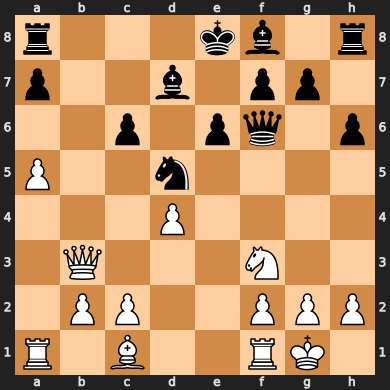

In [18]:
def check_model_prediction(model: torch.nn.Module,
                           random_fen: str,
                           fen_class: int,
                           device=device):
    """Takes the given fen to see the board, predicted score and actual score"""

    numpy_fen = fen_to_vector(random_fen)
    torch_fen = torch.tensor(numpy_fen, dtype=torch.float32).unsqueeze(0).to(device)
    pred = torch.argmax(model(torch_fen), dim=-1)
    print("Model Prediction: ", pred.item())
    print("Stockfish Evaluation: ", fen_class)

# Remember to update fen_class manually
random_fen = "r3kb1r/p2b1pp1/2p1pq1p/P2n4/3P4/1Q3N2/1PP2PPP/R1B2RK1 b kq - 2 14"
check_model_prediction(model=model,
                       random_fen=random_fen,
                       fen_class=5, # remember to manually set 
                       device=device)

board = chess.Board(random_fen)
board

In [19]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for X, _, y_hard in val_dataloader:
        X = X.to(device)
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())

        all_labels.extend(y_hard.numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.76      0.66      0.71     85601
           1       0.53      0.55      0.54     85601
           2       0.52      0.57      0.54     85601
           3       0.54      0.57      0.55     85601
           4       0.55      0.58      0.56     85601
           5       0.53      0.55      0.54     85601
           6       0.76      0.68      0.72     85601

    accuracy                           0.59    599207
   macro avg       0.60      0.59      0.60    599207
weighted avg       0.60      0.59      0.60    599207



In [20]:
import json
import time

LOGS_DIR = f"experiments/logs/{model_save_name}"

def save_config_metadata(experiment_name: str, 
                         model: torch.nn.Module, 
                         hyperparams: dict, 
                         dataset_paths: dict,
                         save_dir: str = LOGS_DIR):
    """
    Saves all 'static' setup details: Model architecture, parameter counts, 
    datasets used, and hyperparameters.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)

    # Model Metadata
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    config_data = {
        "experiment_name": experiment_name,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_architecture": {
            "class_name": model.__class__.__name__,
            "total_parameters": total_params,
            "trainable_parameters": trainable_params,
            "input_dim": hyperparams.get("input_shape", "unknown"),
            "output_dim": hyperparams.get("output_shape", "unknown"),
            "structure_summary": str(model)
        },
        "datasets": dataset_paths,
        "hyperparameters": hyperparams,
        "device": torch.cuda.get_device_name() if torch.cuda.is_available() else "cpu"
    }

    file_path = f"{save_dir}/{experiment_name}_config.json"
    with open(file_path, "w") as f:
        json.dump(config_data, f, indent=4)
    
    print(f"[Config] Saved metadata to {file_path}")
    
def save_training_logs(experiment_name: str, 
                       results_dict: dict, 
                       save_dir: str = LOGS_DIR):
    """
    Saves the epoch-by-epoch learning curves (Loss/Acc) to CSV.
    Expects results_dict to be the output from your run_experiment function.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    df = pd.DataFrame(results_dict)
    
    if "epoch" not in df.columns:
        df["epoch"] = range(1, len(df) + 1)
        
    file_path = f"{save_dir}/{experiment_name}_learning_curves.csv"
    df.to_csv(file_path, index=False)
    
    print(f"[Logs] Saved training history to {file_path}")

In [21]:
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from typing import List, Dict, Tuple

RESULTS_DIR = f"experiments/results/{model_save_name}"

def calculate_ordinal_metrics(preds: np.ndarray,
                              labels: np.ndarray) -> Dict[str, float]:
    """
    Calculates metrics specific to ordinal classification (where Class 0 is close to Class 1).
    """
    abs_diffs = np.abs(preds - labels)
    
    metrics = {
        "mae": float(np.mean(abs_diffs)),
        "off_by_one_accuracy": float(np.mean(abs_diffs <= 1)),
        "off_by_two_accuracy": float(np.mean(abs_diffs <= 2))
    }
    return metrics

def categorize_failures(preds: np.ndarray, 
                        labels: np.ndarray) -> Dict[int, List[int]]:
    """
    Categorizes errors by magnitude.
    Returns a dict where keys are the error magnitude (3, 4, 5, 6) and values are lists of dataset indices.
    """
    abs_diffs = np.abs(preds - labels)
    failure_dict = {}
    
    # We care about errors >= 3 (e.g. Predicting 'Equal' when 'Black Winning')
    # Max error is 6 (Predicting 'White Winning' when 'Black Winning')
    for magnitude in range(3, 7):
        indices = np.where(abs_diffs == magnitude)[0].tolist()
        if indices:
            failure_dict[magnitude] = indices
            
    return failure_dict

def run_inference(model: torch.nn.Module, 
                  dataloader: torch.utils.data.DataLoader, 
                  device: str) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Runs inference and tracks latency. Returns predictions, true labels, and avg latency per sample (ms).
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.inference_mode():
        for X, _, y_hard in dataloader:
            X = X.to(device)
            preds = model(X).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_hard.numpy())
            

    total_time = time.time() - start_time
    num_samples = len(all_labels)
    avg_latency_ms = (total_time / num_samples) * 1000
    
    return np.array(all_preds), np.array(all_labels), avg_latency_ms

def save_test_results(experiment_name: str, 
                      model: torch.nn.Module, 
                      test_dataloader: torch.utils.data.DataLoader, 
                      device: str,
                      save_dir: str = RESULTS_DIR):
    """
    Orchestrates the testing process and saves all research-grade metrics.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
        
    preds, labels, latency_ms = run_inference(model, test_dataloader, device)

    acc = accuracy_score(labels, preds)
    class_report = classification_report(labels, preds, output_dict=True)
    conf_matrix = confusion_matrix(labels, preds)
    ordinal_metrics = calculate_ordinal_metrics(preds, labels)
    failure_indices = categorize_failures(preds, labels)
    
    final_metrics = {
        "experiment_name": experiment_name,
        "global_accuracy": acc,
        "inference_latency_ms": latency_ms,
        "ordinal_metrics": ordinal_metrics,
        "catastrophic_failure_counts": {k: len(v) for k, v in failure_indices.items()},
        "classification_report": class_report
    }

    json_path = f"{save_dir}/{experiment_name}_metrics.json"
    with open(json_path, "w") as f:
        json.dump(final_metrics, f, indent=4)
        
    npy_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    np.save(npy_path, conf_matrix)
    
    # Failure Indices JSON (for later visual analysis of specific FENs)
    failures_path = f"{save_dir}/{experiment_name}_failure_indices.json"
    with open(failures_path, "w") as f:
        json.dump(failure_indices, f)
    
    print("-" * 60)
    print(f"[Results] Accuracy:        {acc*100:.2f}%")
    print(f"[Results] Off-by-1 Acc:    {ordinal_metrics['off_by_one_accuracy']*100:.2f}%")
    print(f"[Results] MAE:             {ordinal_metrics['mae']:.4f}")
    print(f"[Results] Latency:         {latency_ms:.4f} ms/sample")
    print("[Results] Catastrophic Failures (Count):")
    for k in sorted(failure_indices.keys()):
        print(f"   - Off by {k}: {len(failure_indices[k])} samples")
    print(f"[Results] Saved all metrics to {save_dir}")
    print("-" * 60)


In [22]:
hyperparams = {
    "epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": 0.001,
    "optimizer": "AdamW",
    "input_shape": 775,
    "output_shape": 7
}

dataset_paths = {
    "train": str(ROOT_DIR / "train_X.npy"),
    "val":   str(ROOT_DIR / "val_X.npy"),
    "test":  str(ROOT_DIR / "test_X.npy")
}

save_config_metadata(experiment_name=RUN_ID,
                     model=model,
                     hyperparams=hyperparams,
                     dataset_paths=dataset_paths)

# Save Training Logs (Using the 'result' variable from run_experiment)
save_training_logs(experiment_name=RUN_ID, 
                   results_dict=result)

save_test_results(experiment_name=RUN_ID,
                  model=model,
                  test_dataloader=test_dataloader,
                  device=device)

[Config] Saved metadata to experiments/logs/probs_mlp_v5/run_2026_01_22_probs_mlp_v5_config.json
[Logs] Saved training history to experiments/logs/probs_mlp_v5/run_2026_01_22_probs_mlp_v5_learning_curves.csv
------------------------------------------------------------
[Results] Accuracy:        59.16%
[Results] Off-by-1 Acc:    88.37%
[Results] MAE:             0.6066
[Results] Latency:         0.0635 ms/sample
[Results] Catastrophic Failures (Count):
   - Off by 3: 19414 samples
   - Off by 4: 6738 samples
   - Off by 5: 3357 samples
   - Off by 6: 1394 samples
[Results] Saved all metrics to experiments/results/probs_mlp_v5
------------------------------------------------------------


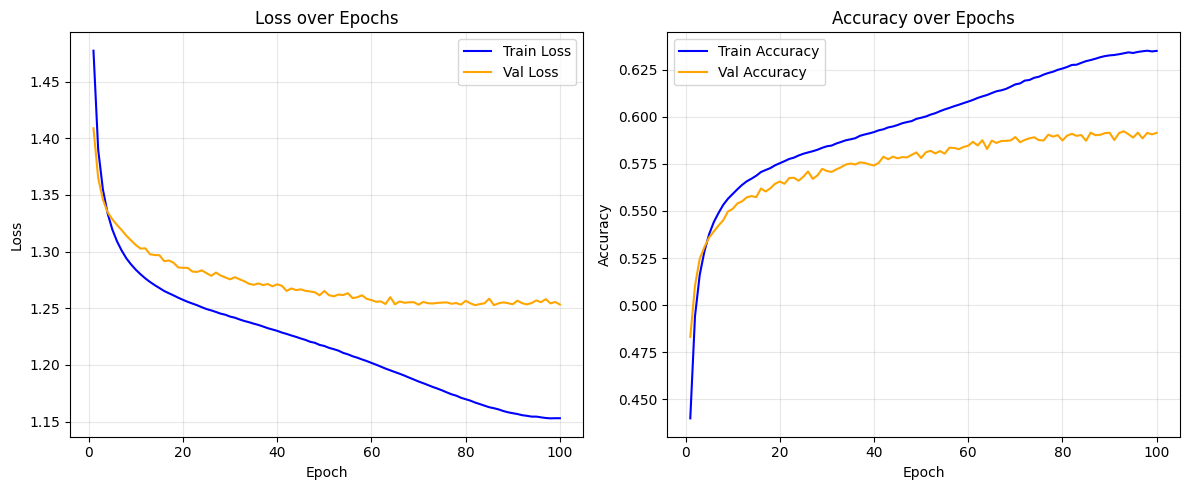

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = Path(f"./experiments/logs/{model_save_name}/{RUN_ID}_learning_curves.csv")
df = pd.read_csv(file_path)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', color='blue')
plt.plot(df['epoch'], df['val_acc'], label='Val Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()